In [1]:
import numpy as np
import torch
import torchvision

In [2]:
train_ds = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor()
)

test_ds = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor()
)

In [3]:
batch_size=64
train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, num_workers=2
)

In [4]:
for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([64])


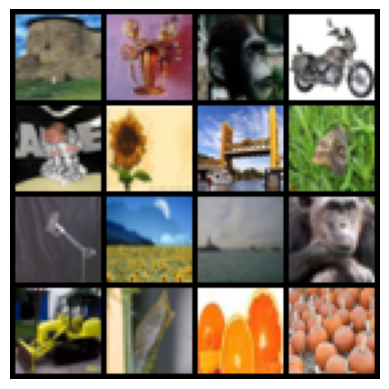

In [5]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

grid = make_grid(X[:16], nrow=4).permute(1, 2, 0).numpy()
plt.imshow(grid)
plt.axis('off')
plt.show()

In [6]:
device = torch.accelerator.current_accelerator()
print(device)

cuda


In [7]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(32*32*3, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 100)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [8]:
model = NeuralNetwork().to(device)  # to manually send the model to the GPU
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=100, bias=True)
  )
)


In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [10]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()       # Set the model in training config
    for batch, (X,y) in enumerate(dataloader):
        # Send X and y to GPU because by default they live on the CPU, but during training they must be on the GPU since our model is also on GPU. Otherwise, RunTimeError (model, X, y must be on the same device)
        X, y = X.to(device), y.to(device)

        pred = model(X)     # compute predictions (this calls model's forward() )
        loss = loss_fn(pred, y) # compute loss

        # Backprop
        # This calculates the gradients and stores them for each param.grad in model.parameters()
        loss.backward()     # Remember that backward() is not a method of model, but of a tensor

        # This updates the weights based on the optimizer and the grads above
        optimizer.step()    # Updates happen to model automatically because of PyTorch's dynamic graph, even if we do not update "model" explicitly

        # Clear grads for next step
        optimizer.zero_grad()

        # Print updates every 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f'loss: {loss}    [{current}/{size}]')

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    batches = len(dataloader)
    model.eval()
    test_loss, correct = 0,0    # manually define accuracy (or any other metric)
    with torch.no_grad():   # pause grad tracking because it's not needed during test phase
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)     # shape [batch_size, num_classes] because class probabilities of each class
            test_loss += loss_fn(pred, y).item()    # item() extract the scalar out of a tensor
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= batches
    correct /= size
    print(f'Accuracy: {correct} \n Loss: {test_loss}')


In [15]:
epochs=500
for t in range(epochs):
    print(f'Epoch {t+1} \n----------------')
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print('Done!')

Epoch 1 
----------------
loss: 3.8287386894226074    [64/50000]
loss: 3.8001577854156494    [6464/50000]
loss: 3.7726387977600098    [12864/50000]
loss: 3.8509654998779297    [19264/50000]
loss: 3.855854034423828    [25664/50000]
loss: 3.6916184425354004    [32064/50000]
loss: 3.5058858394622803    [38464/50000]
loss: 3.7181661128997803    [44864/50000]
Accuracy: 0.1321 
 Loss: 3.8099697835885795
Epoch 2 
----------------
loss: 4.200137138366699    [64/50000]
loss: 3.727677822113037    [6464/50000]
loss: 3.913544178009033    [12864/50000]
loss: 3.6187548637390137    [19264/50000]
loss: 4.06683349609375    [25664/50000]
loss: 3.830537796020508    [32064/50000]
loss: 3.6233932971954346    [38464/50000]
loss: 3.98343563079834    [44864/50000]
Accuracy: 0.1325 
 Loss: 3.8025837430528773
Epoch 3 
----------------
loss: 3.6867380142211914    [64/50000]
loss: 3.8647031784057617    [6464/50000]
loss: 3.923689842224121    [12864/50000]
loss: 3.82830548286438    [19264/50000]
loss: 3.9551386833

In [18]:
torch.save(model.state_dict(), 'saved/model.pth')   # Save serialized state dictionary (containing weights)

In [19]:
model = NeuralNetwork().to(device)  # send the architecture to GPU (must be defined and match the saved model)
model.load_state_dict(torch.load('saved/model.pth', weights_only=True))

<All keys matched successfully>